In [10]:
%load_ext autoreload
%autoreload 2

import dolfin
import numpy
import scipy.optimize
from scipy.interpolate import interp1d

import dolfin_mech     as dmech
import matplotlib.pyplot as plt
import micro_poro_structure_generator as gen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
qois_filename = "Fig6-qois.dat"
res_basename = "Fig6"
seeds_filename = "ch4.dat"
mesh_filebasename = "ch4-mesh"


load_params = {}
load_params["pf"] = 4
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

In [12]:
def graph_printer(thickness, params, linestyle):
    
    domain_y = 1
    domain_x = domain_y * numpy.sqrt(3)/1.5/2
    # thickness = 0.12

    gen.generate_seeds_semi_regular(
        DoI = 0.,
        row = 1,
        domain_y = domain_y,
        seeds_filename = seeds_filename)
    phi = gen.generate_mesh_2D_rectangle_w_voronoi_inclusions(
        mesh_filename = mesh_filebasename,
        seeds_filename = seeds_filename,
        h = thickness,
        lcar = thickness/5,
        domain_x = domain_x,
        domain_y = domain_y,
        shift_y = 0.,
        remove_seeds = True)

    mesh = dolfin.Mesh()
    dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
    dV = dolfin.Measure("dx",domain=mesh)

    coord = mesh.coordinates()
    xmax = max(coord[:,0]); xmin = min(coord[:,0])
    ymax = max(coord[:,1]); ymin = min(coord[:,1])

    V = (xmax - xmin)*(ymax - ymin)
    VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
    Vf0 = V - VS0

    mat_params = {"model":"exponential", "parameters":{"beta1":params[0], "beta2":params[1], "beta3":params[2], "alpha":params[3]}}

    dmech.run_HollowBox_MicroPoroHyperelasticity(
        dim=2,
        mesh=mesh,
        mat_params=mat_params,
        load_params=load_params,
        step_params={"Deltat":1., "dt_ini":0.1, "dt_min":0.001, "dt_max":0.005},
        res_basename=res_basename,
        write_qois_limited_precision=False,
        verbose=1
    )

    qois_vals = numpy.loadtxt(qois_filename)
    qois_name_list = open(qois_filename).readline().split()
    pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
    vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

    for i in range(1, len(vf_lst)):
        slope = (vf_lst[i] - vf_lst[i - 1])/(pf_lst[i] - pf_lst[i - 1])
        if slope < 0.0005:
            break

    vf_asym = vf_lst[i]
    vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]

    print("pf_asym: {:.2f} cmH2O".format(pf_lst[i]))

    

    plt.plot(pf_lst, vf_lst, '#084594', label='$\Phi_{f0} = '+str('{:.2f}'.format(phi))+'\%$', linestyle=linestyle)

    plt.xlim(0, 25)
    plt.legend(loc = 'lower right', fontsize=12, shadow=True)

[[0.28867513 0.25      ]
 [0.         0.75      ]
 [0.8660254  0.25      ]
 [0.57735027 0.75      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 140 (Line)
Info    : [ 20%] Meshing curve 141 (Line)
Info    : [ 30%] Meshing curve 142 (Line)
Info    : [ 30%] Meshing curve 143 (Line)
Info    : [ 30%] Meshing curve 144 (Line)
Info    : [ 40%] Meshing curve 145 (Line)
Info    : [ 40%] Meshing curve 146 (Line)
Info    : [ 50%] Meshing curve 147 (Line)
Info    : [ 50%] Meshing curve 148 (Line)
Info    : [ 50%] Meshing curve 149 (Line)
Info    : [ 60%] Meshing curve 150 (Line)
Info    : [ 60%] Meshing curve 151 (Line)
Info    : [ 70%] Meshing curve 152 (Line)
Info    : [ 70%] Meshing curve 153 (Line)
Info    : [ 80%] Meshing curve 154 (Line)
Info    : [ 80%] Meshing curve 

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  m = (Q[1] - P[1])/(Q[0] - P[0])
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:61: RuntimeWarning: invalid value encountered in double_scalars
  x = (c2 - c1)/(m1 - m2)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:62: RuntimeWarning: invalid value encountered in double_scalars
  y = (m2*c1 - m1*c2)/(m2 - m1)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:45: RuntimeWarning: invalid value encountered in double_scalars
  c = P[1] - m * P[0]


Info    : Running '/Users/tayebi/miniconda3/envs/all/bin/gmsh -2 -o ch4-mesh.msh -format msh22 ch4-mesh.msh' [Gmsh 4.9.0, 1 node, max. 1 thread]
Info    : Started on Mon May 20 19:37:29 2024
Info    : Reading 'ch4-mesh.msh'...
Info    : 63 entities
Info    : 591 nodes
Info    : 964 elements
Info    : Done reading 'ch4-mesh.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 5.2031e-05s, CPU 0.000269s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 2.8357e-05s, CPU 0.000165s)
Info    : 603 nodes 998 elements
Info    : Writing 'ch4-mesh.msh'...
Info    : Done writing 'ch4-mesh.msh'
Info    : Stopped on Mon May 20 19:37:29 2024 (From start: Wall 0.00795696s, CPU 0.248382s)
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 591 vertices
Found all vertices
Expecting 964 cells
Found all cells
Conversion done
Phis0=0.37249219381653115
Phif0=0.6275078061834689


/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/ufl/exproperators.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


pf_asym: 40.80 cmH2O
[[0.28867513 0.25      ]
 [0.         0.75      ]
 [0.8660254  0.25      ]
 [0.57735027 0.75      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 152 (Line)
Info    : [ 20%] Meshing curve 153 (Line)
Info    : [ 20%] Meshing curve 154 (Line)
Info    : [ 30%] Meshing curve 155 (Line)
Info    : [ 30%] Meshing curve 156 (Line)
Info    : [ 30%] Meshing curve 157 (Line)
Info    : [ 40%] Meshing curve 158 (Line)
Info    : [ 40%] Meshing curve 159 (Line)
Info    : [ 40%] Meshing curve 160 (Line)
Info    : [ 50%] Meshing curve 161 (Line)
Info    : [ 50%] Meshing curve 162 (Line)
Info    : [ 50%] Meshing curve 163 (Line)
Info    : [ 60%] Meshing curve 164 (Line)
Info    : [ 60%] Meshing curve 165 (Line)
Info    : [ 70%] Meshing curve 166 (Line)
Info    : 

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  m = (Q[1] - P[1])/(Q[0] - P[0])
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:61: RuntimeWarning: invalid value encountered in double_scalars
  x = (c2 - c1)/(m1 - m2)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:62: RuntimeWarning: invalid value encountered in double_scalars
  y = (m2*c1 - m1*c2)/(m2 - m1)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:45: RuntimeWarning: invalid value encountered in double_scalars
  c = P[1] - m * P[0]


Info    : Running '/Users/tayebi/miniconda3/envs/all/bin/gmsh -2 -o ch4-mesh.msh -format msh22 ch4-mesh.msh' [Gmsh 4.9.0, 1 node, max. 1 thread]
Info    : Started on Mon May 20 19:38:12 2024
Info    : Reading 'ch4-mesh.msh'...
Info    : 63 entities
Info    : 799 nodes
Info    : 1310 elements
Info    : Done reading 'ch4-mesh.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 5.4154e-05s, CPU 0.000188s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 3.227e-05s, CPU 0.000115s)
Info    : 811 nodes 1344 elements
Info    : Writing 'ch4-mesh.msh'...
Info    : Done writing 'ch4-mesh.msh'
Info    : Stopped on Mon May 20 19:38:12 2024 (From start: Wall 0.00914496s, CPU 0.255422s)
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 799 vertices
Found all vertices
Expecting 1310 cells
Found all cells
Conversion done
Phis0=0.2874691453623976
Phif0=0.7125308546376024


/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/ufl/exproperators.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


pf_asym: 40.80 cmH2O


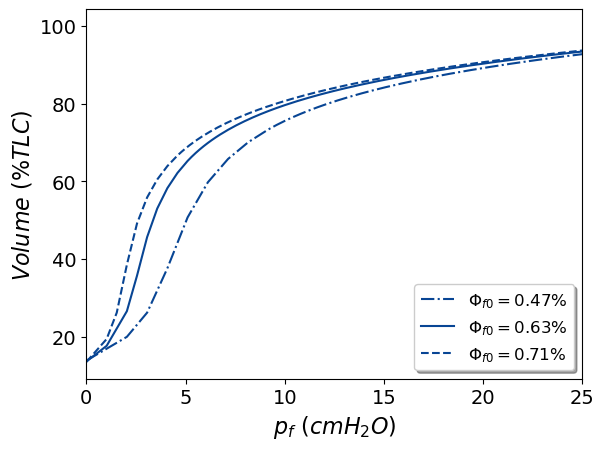

In [13]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

params = [0.08855929243285596, 0.011039510924095856, 0.6281487879627474, 3.409513378002055]
graph_printer(0.18, params, 'dashdot')
graph_printer(0.12, params, None)
graph_printer(0.09, params, 'dashed')
plt.savefig('Porosity_compare.pdf',bbox_inches='tight')

plt.show()
